In [9]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

# Merge Data 

In [10]:
nhs=pd.read_csv('nhsRegion_2022-04-01.csv')
region= pd.read_csv('region_2022-04-01.csv')
ulta=pd.read_csv('utla_2022-04-01.csv')
vac=pd.read_csv('data_2022-Apr-05.csv')

In [15]:
def get_API_data(filters, structure):
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"
    # pack parameters
    api_params = {
        "filters": str.join(";", filters),
        "structure": json.dumps(structure, separators=(",", ":")),
        "page":1
        }
    response = requests.get(endpoint, params=api_params, timeout = 50)  # send request
    
    # running into problem when status_code >=400
    if response.status_code >= 400:
        raise RuntimeError(f'Request failed: { response.text }')
        
    result = response.json()
    return result['data']

In [16]:
query_filters = ['areaType=region','areaName=London']
# the data we require
query_structure = {
    "date": "date",
    "name": "areaName",
    "daily_cases": "newCasesBySpecimenDate",
    "daily_cases_age": "newCasesBySpecimenDateAgeDemographics",
    "cumulative_cases": "cumCasesBySpecimenDate",
    "daily_deaths": "newDeaths28DaysByPublishDate",
    "daily_deaths_age": "newDeaths28DaysByDeathDateAgeDemographics",
    "cumulative_deaths": "cumDeaths28DaysByPublishDate",
    "cumulative_vaccinated": "cumPeopleVaccinatedSecondDoseByVaccinationDate",
    "vaccination_age": "vaccinationsAgeDemographics"
}
# get national data
results_json = get_API_data(query_filters, query_structure)

In [17]:
london_covid = pd.json_normalize(results_json)
london_covid.dropna(inplace=True)
london_covid

,date,name,daily_cases,daily_cases_age,cumulative_cases,daily_deaths,daily_deaths_age,cumulative_deaths,cumulative_vaccinated,vaccination_age
1,2022-04-04,London,2928.0,[],2810603.0,11.0,[],19188.0,5998364.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
2,2022-04-03,London,3570.0,[],2807675.0,0.0,[],19177.0,5996873.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
3,2022-04-02,London,3614.0,[],2804105.0,0.0,[],19177.0,5996068.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
4,2022-04-01,London,4937.0,[],2800491.0,11.0,[],19177.0,5993754.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
5,2022-03-31,London,5691.0,"[{'age': '00_04', 'cases': 115, 'rollingSum': ...",2795554.0,5.0,"[{'age': '00_04', 'deaths': 0, 'rollingSum': 0...",19166.0,5991768.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
...,...,...,...,...,...,...,...,...,...,...
479,2020-12-12,London,4749.0,"[{'age': '00_04', 'cases': 137, 'rollingSum': ...",211609.0,28.0,"[{'age': '00_04', 'deaths': 0, 'rollingSum': 0...",7424.0,1350.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
480,2020-12-11,London,5538.0,"[{'age': '00_04', 'cases': 151, 'rollingSum': ...",206860.0,34.0,"[{'age': '00_04', 'deaths': 0, 'rollingSum': 0...",7396.0,1350.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
481,2020-12-10,London,5080.0,"[{'age': '00_04', 'cases': 140, 'rollingSum': ...",201322.0,40.0,"[{'age': '00_04', 'deaths': 0, 'rollingSum': 0...",7362.0,1350.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
482,2020-12-09,London,4462.0,"[{'age': '00_04', 'cases': 119, 'rollingSum': ...",196242.0,35.0,"[{'age': '00_04', 'deaths': 0, 'rollingSum': 0...",7322.0,1341.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."


In [24]:
london_covid.date=pd.to_datetime(london_covid.date, infer_datetime_format=True)
region.date=pd.to_datetime(region.date, infer_datetime_format=True)
vac.date=pd.to_datetime(vac.date, infer_datetime_format=True)
nhs.date=pd.to_datetime(nhs.date, infer_datetime_format=True)

In [26]:
covid=london_covid.merge(vac, left_on='date', right_on='date')

In [37]:
covid.columns.tolist()

['date',
 'name',
 'daily_cases',
 'daily_cases_age',
 'cumulative_cases',
 'daily_deaths',
 'daily_deaths_age',
 'cumulative_deaths',
 'cumulative_vaccinated',
 'vaccination_age',
 'areaType_x',
 'areaName_x',
 'areaCode_x',
 'newPeopleVaccinatedFirstDoseByVaccinationDate',
 'cumPeopleVaccinatedFirstDoseByVaccinationDate',
 'newPeopleVaccinatedSecondDoseByVaccinationDate',
 'cumPeopleVaccinatedSecondDoseByVaccinationDate',
 'newPeopleVaccinatedThirdInjectionByVaccinationDate',
 'cumPeopleVaccinatedThirdInjectionByVaccinationDate',
 'areaCode_y',
 'areaName_y',
 'areaType_y',
 'covidOccupiedMVBeds',
 'hospitalCases',
 'newAdmissions',
 'newAdmissionsRollingSum']

In [36]:
covid=covid.merge(nhs, left_on='date', right_on='date')

In [38]:
covid_select=covid[['date','name','daily_cases','cumulative_cases','daily_deaths',
                    'cumulative_deaths','newPeopleVaccinatedFirstDoseByVaccinationDate',
                   'cumPeopleVaccinatedFirstDoseByVaccinationDate',
 'newPeopleVaccinatedSecondDoseByVaccinationDate',
 'cumPeopleVaccinatedSecondDoseByVaccinationDate',
 'newPeopleVaccinatedThirdInjectionByVaccinationDate',
 'cumPeopleVaccinatedThirdInjectionByVaccinationDate','covidOccupiedMVBeds','hospitalCases','newAdmissions','newAdmissionsRollingSum']]

In [39]:
covid_select

,date,name,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,newPeopleVaccinatedFirstDoseByVaccinationDate,cumPeopleVaccinatedFirstDoseByVaccinationDate,newPeopleVaccinatedSecondDoseByVaccinationDate,cumPeopleVaccinatedSecondDoseByVaccinationDate,newPeopleVaccinatedThirdInjectionByVaccinationDate,cumPeopleVaccinatedThirdInjectionByVaccinationDate,covidOccupiedMVBeds,hospitalCases,newAdmissions,newAdmissionsRollingSum
0,2022-04-01,London,4937.0,2800491.0,11.0,19177.0,750,6448275,1986,5993754,2542.0,4276592.0,99.0,2448.0,NaN,NaN
1,2022-03-31,London,5691.0,2795554.0,5.0,19166.0,645,6447525,1558,5991768,2168.0,4274050.0,100.0,2434.0,NaN,NaN
2,2022-03-30,London,7893.0,2789863.0,9.0,19161.0,613,6446880,1573,5990210,2390.0,4271882.0,104.0,2330.0,231.0,1563.0
3,2022-03-29,London,8356.0,2781970.0,18.0,19152.0,533,6446267,1589,5988637,2465.0,4269492.0,109.0,2324.0,264.0,1543.0
4,2022-03-28,London,9438.0,2773614.0,14.0,19134.0,590,6445734,1603,5987048,2659.0,4267027.0,103.0,2266.0,263.0,1492.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2020-12-12,London,4749.0,211609.0,28.0,7424.0,863,6805,0,1350,NaN,NaN,256.0,2092.0,246.0,1598.0
476,2020-12-11,London,5538.0,206860.0,34.0,7396.0,1433,5942,0,1350,NaN,NaN,261.0,2031.0,277.0,1493.0
477,2020-12-10,London,5080.0,201322.0,40.0,7362.0,1409,4509,9,1350,NaN,NaN,256.0,1934.0,235.0,1386.0
478,2020-12-09,London,4462.0,196242.0,35.0,7322.0,878,3100,9,1341,NaN,NaN,241.0,1787.0,248.0,1307.0


In [40]:
covid_select = covid_select.rename(columns={'newPeopleVaccinatedFirstDoseByVaccinationDate': 'FirstDose', 
                                            'cumPeopleVaccinatedFirstDoseByVaccinationDate': 'cumFirstDose',
                                            'newPeopleVaccinatedSecondDoseByVaccinationDate': 'SecondDose',
 'cumPeopleVaccinatedSecondDoseByVaccinationDate':'cumSecondDose',
 'newPeopleVaccinatedThirdInjectionByVaccinationDate':'ThirdDose',
 'cumPeopleVaccinatedThirdInjectionByVaccinationDate':'cumThirdDose'
                                           })

# Ploting

In [41]:
covid_select

,date,name,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,FirstDose,cumFirstDose,SecondDose,cumSecondDose,ThirdDose,cumThirdDose,covidOccupiedMVBeds,hospitalCases,newAdmissions,newAdmissionsRollingSum
0,2022-04-01,London,4937.0,2800491.0,11.0,19177.0,750,6448275,1986,5993754,2542.0,4276592.0,99.0,2448.0,NaN,NaN
1,2022-03-31,London,5691.0,2795554.0,5.0,19166.0,645,6447525,1558,5991768,2168.0,4274050.0,100.0,2434.0,NaN,NaN
2,2022-03-30,London,7893.0,2789863.0,9.0,19161.0,613,6446880,1573,5990210,2390.0,4271882.0,104.0,2330.0,231.0,1563.0
3,2022-03-29,London,8356.0,2781970.0,18.0,19152.0,533,6446267,1589,5988637,2465.0,4269492.0,109.0,2324.0,264.0,1543.0
4,2022-03-28,London,9438.0,2773614.0,14.0,19134.0,590,6445734,1603,5987048,2659.0,4267027.0,103.0,2266.0,263.0,1492.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2020-12-12,London,4749.0,211609.0,28.0,7424.0,863,6805,0,1350,NaN,NaN,256.0,2092.0,246.0,1598.0
476,2020-12-11,London,5538.0,206860.0,34.0,7396.0,1433,5942,0,1350,NaN,NaN,261.0,2031.0,277.0,1493.0
477,2020-12-10,London,5080.0,201322.0,40.0,7362.0,1409,4509,9,1350,NaN,NaN,256.0,1934.0,235.0,1386.0
478,2020-12-09,London,4462.0,196242.0,35.0,7322.0,878,3100,9,1341,NaN,NaN,241.0,1787.0,248.0,1307.0


<AxesSubplot:xlabel='date'>

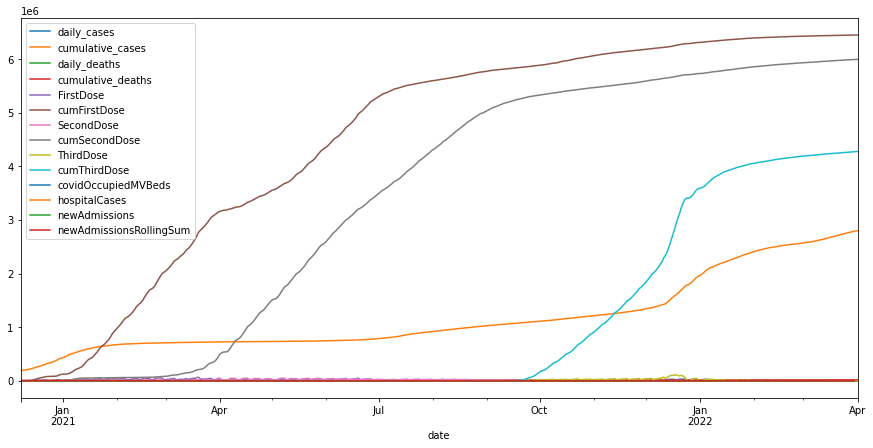

In [46]:
covid_select.set_index('date').plot(figsize=(15,7))


In [53]:
covid_daily =covid_select[['date','daily_cases','daily_deaths','FirstDose','SecondDose','ThirdDose','covidOccupiedMVBeds',
                           'hospitalCases','newAdmissions']]

<AxesSubplot:xlabel='date'>

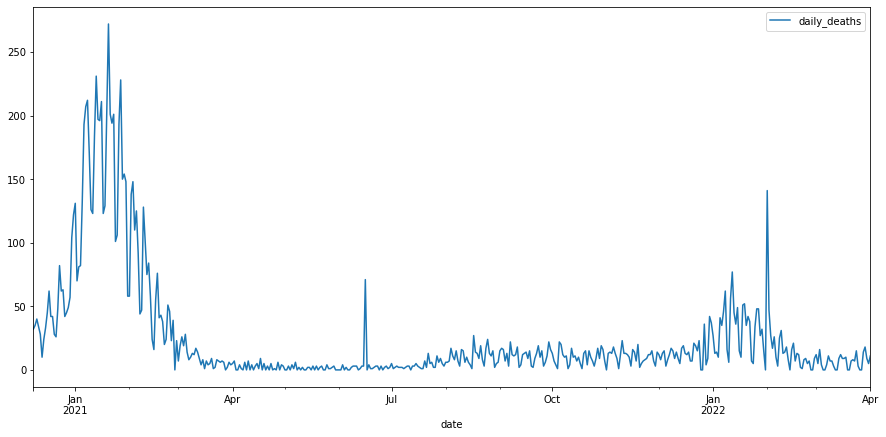

In [54]:
covid_daily.set_index('date').plot(figsize=(15,7),y=['daily_deaths'])

<AxesSubplot:xlabel='date'>

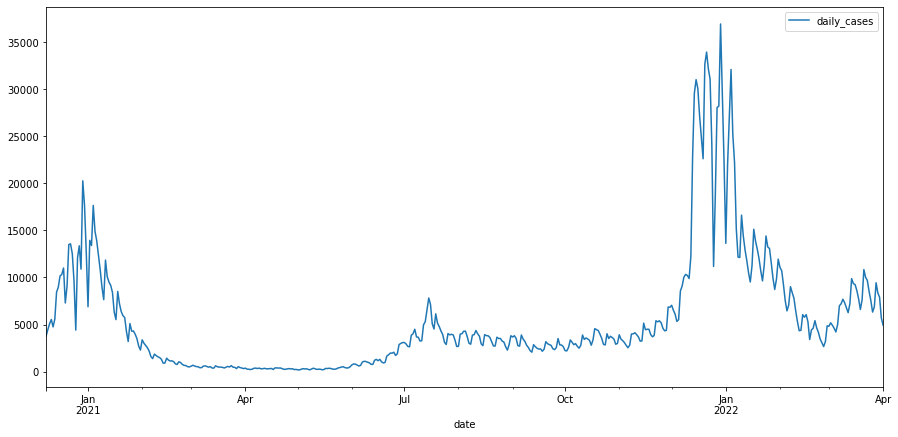

In [55]:
covid_daily.set_index('date').plot(figsize=(15,7),y=['daily_cases'])

<AxesSubplot:xlabel='date'>

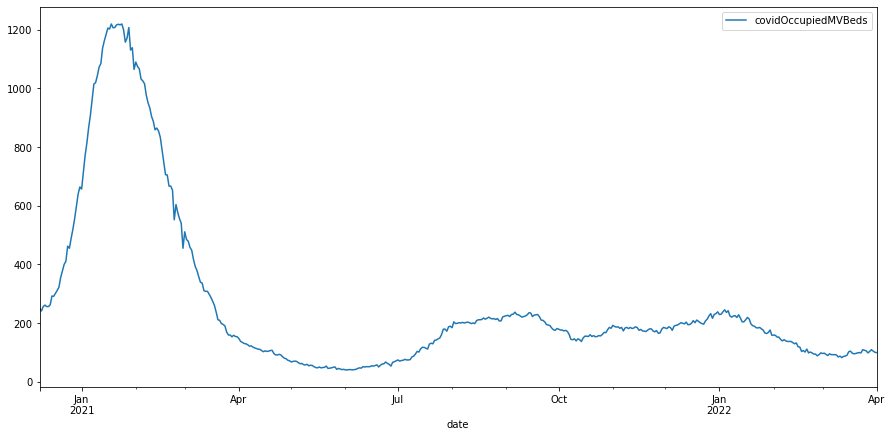

In [57]:
covid_daily.set_index('date').plot(figsize=(15,7),y=['covidOccupiedMVBeds'])

<AxesSubplot:xlabel='date'>

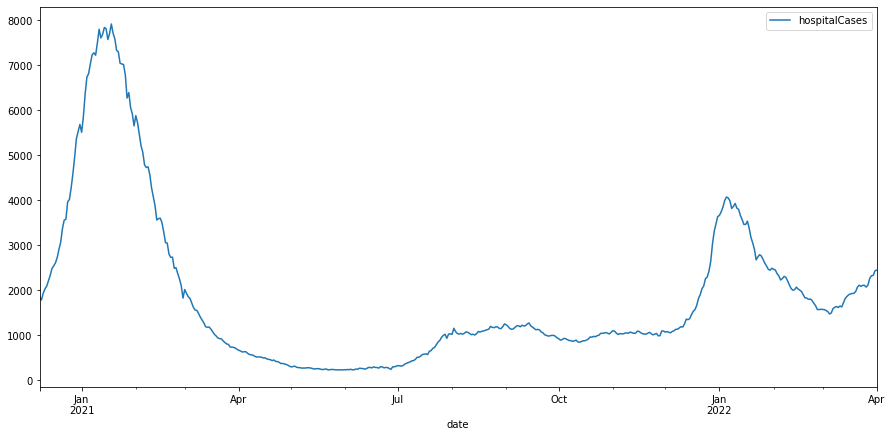

In [58]:
covid_daily.set_index('date').plot(figsize=(15,7),y=['hospitalCases'])

<AxesSubplot:xlabel='date'>

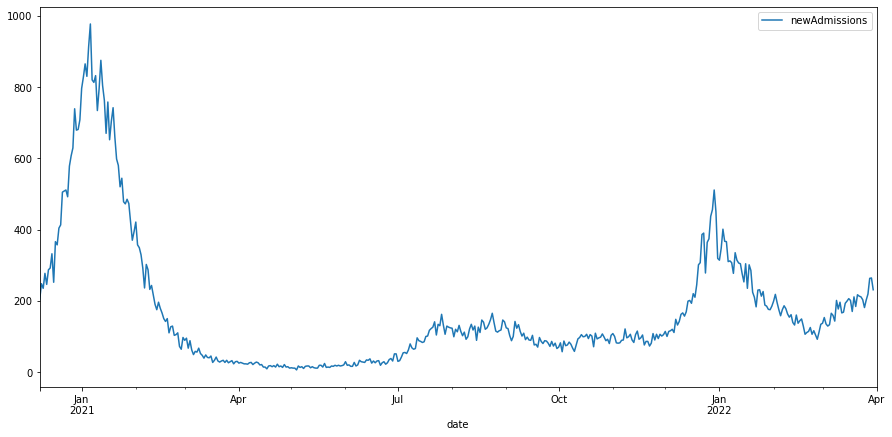

In [59]:
covid_daily.set_index('date').plot(figsize=(15,7),y=['newAdmissions'])

<AxesSubplot:xlabel='date'>

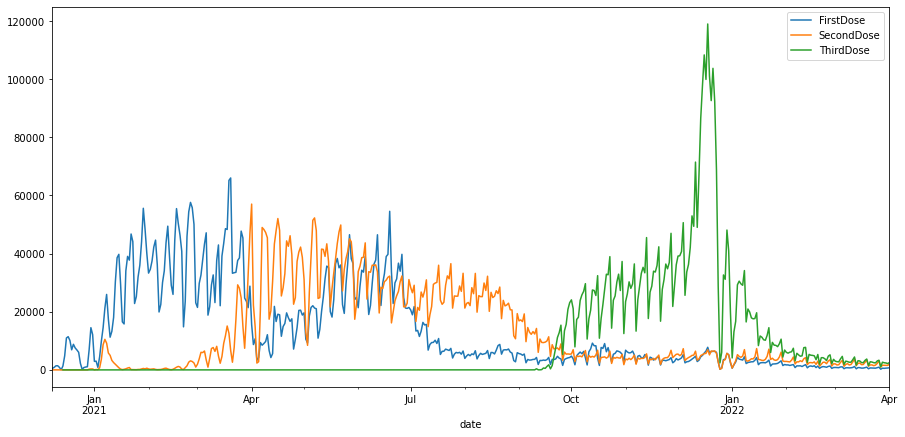

In [60]:
covid_daily.set_index('date').plot(figsize=(15,7),y=['FirstDose','SecondDose','ThirdDose'])

# Correlation

In [56]:
covid_daily.corr()

,daily_cases,daily_deaths,FirstDose,SecondDose,ThirdDose,covidOccupiedMVBeds,hospitalCases,newAdmissions
daily_cases,1.000000,0.177776,-0.381631,-0.388681,0.604181,0.081452,0.385709,0.544503
daily_deaths,0.177776,1.000000,0.286063,-0.345090,-0.108002,0.866628,0.875417,0.787575
FirstDose,-0.381631,0.286063,1.000000,0.259601,-0.305837,0.396096,0.119968,-0.068151
SecondDose,-0.388681,-0.345090,0.259601,1.000000,-0.280382,-0.416107,-0.541235,-0.476102
ThirdDose,0.604181,-0.108002,-0.305837,-0.280382,1.000000,-0.137189,-0.069908,0.023572
covidOccupiedMVBeds,0.081452,0.866628,0.396096,-0.416107,-0.137189,1.000000,0.881903,0.722927
hospitalCases,0.385709,0.875417,0.119968,-0.541235,-0.069908,0.881903,1.000000,0.914498
newAdmissions,0.544503,0.787575,-0.068151,-0.476102,0.023572,0.722927,0.914498,1.000000


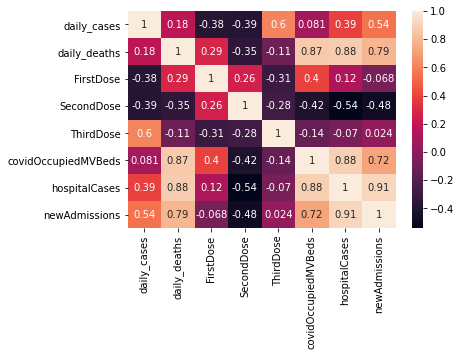

In [62]:
corrMatrix = covid_daily.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [64]:
covid_daily.to_csv('mergedCase.csv')

In [65]:
covid.to_csv('mergedCaseAll.csv')